# Problem 4.3 – Variational Autoencoder (VAE)

## 4.3.1 Conceptual introduction to Variational Autoencoders (VAEs)

A Variational Autoencoder (VAE) is a generative model that learns a probabilistic latent representation of data.
It consists of:
- an encoder $q_\phi(\mathbf{z}\mid\mathbf{x})$ that maps data $\mathbf{x}$ to a distribution over latent variables $\mathbf{z}$,
- a decoder $p_\theta(\mathbf{x}\mid\mathbf{z})$ that maps latent variables back to a distribution over data.

### Notation and assumptions
- Prior on latent variables: $p(\mathbf{z}) = \mathcal{N}(\mathbf{0}, \mathbf{I})$.
- Variational posterior (encoder): $q_\phi(\mathbf{z}\mid\mathbf{x}) = \mathcal{N}\!\big(\boldsymbol\mu_\phi(\mathbf{x}), \mathrm{diag}(\boldsymbol\sigma^2_\phi(\mathbf{x}))\big)$.
  In practice we predict $\boldsymbol\mu$ and $\log\boldsymbol\sigma^2$ (aka `logvar`) for numerical stability.
- Likelihood (decoder): $p_\theta(\mathbf{x}\mid\mathbf{z})$.
  - If we use mean squared error (MSE) as reconstruction loss, this corresponds to a Gaussian likelihood with fixed variance: $p_\theta(\mathbf{x}\mid\mathbf{z}) = \mathcal{N}(\hat{\mathbf{x}}_\theta(\mathbf{z}), \beta \mathbf{I})$ (for some $\beta>0$).
  - If we use binary cross-entropy (BCE) on $[0,1]$ images, this corresponds to a Bernoulli likelihood with mean $\hat{\mathbf{x}}_\theta(\mathbf{z})$.

### Objective: ELBO
Maximizing the log marginal likelihood $\log p_\theta(\mathbf{x})$ directly is intractable,
so we maximize the Evidence Lower BOund (ELBO):
$$
\mathcal{L}_{\text{ELBO}}(\theta,\phi;\mathbf{x})
= \mathbb{E}_{q_\phi(\mathbf{z}\mid\mathbf{x})}\big[\log p_\theta(\mathbf{x}\mid\mathbf{z})\big]
- \mathrm{KL}\!\big(q_\phi(\mathbf{z}\mid\mathbf{x}) \,\|\, p(\mathbf{z})\big).
$$
Training conventionally minimizes the negative ELBO:
$$
\mathcal{L}_{\text{VAE}}(\mathbf{x})
= -\,\mathbb{E}_{q_\phi(\mathbf{z}\mid\mathbf{x})}\big[\log p_\theta(\mathbf{x}\mid\mathbf{z})\big]
+ \mathrm{KL}\!\big(q_\phi(\mathbf{z}\mid\mathbf{x}) \,\|\, p(\mathbf{z})\big).
$$

For Gaussian decoder with fixed variance $\beta\mathbf{I}$, the first term reduces (up to a constant scale) to the per-pixel MSE between $\mathbf{x}$ and $\hat{\mathbf{x}}=\hat{\mathbf{x}}_\theta(\mathbf{z})$:
$$
-\,\mathbb{E}_{q}\big[\log p_\theta(\mathbf{x}\mid\mathbf{z})\big]
\propto \frac{1}{2\beta}\,\|\mathbf{x}-\hat{\mathbf{x}}\|_2^2.
$$
In practice we implement it as an MSE over pixels/channels, reduced to a scalar per batch.

### Closed-form KL for diagonal Gaussians
With $q_\phi(\mathbf{z}\mid\mathbf{x})=\mathcal{N}(\boldsymbol\mu, \mathrm{diag}(\boldsymbol\sigma^2))$ and $p(\mathbf{z})=\mathcal{N}(\mathbf{0},\mathbf{I})$:
$$
\mathrm{KL}\!\big(q \,\|\, p\big)
= \frac{1}{2}\sum_{i=1}^d \big(\mu_i^2 + \sigma_i^2 - \log \sigma_i^2 - 1\big).
$$
Using `logvar = \log \sigma^2`, one computes $\sigma^2 = \exp(\text{logvar})$ and uses the same formula.

### Reparameterization trick
To backpropagate through sampling from $q_\phi(\mathbf{z}\mid\mathbf{x})$, we write
$$
\mathbf{z} = \boldsymbol\mu + \boldsymbol\sigma \odot \boldsymbol\epsilon,
\quad \boldsymbol\epsilon \sim \mathcal{N}(\mathbf{0},\mathbf{I}),
\quad \boldsymbol\sigma = \exp\!\big(\tfrac{1}{2}\,\text{logvar}\big).
$$
This makes sampling a deterministic function of $(\boldsymbol\mu,\text{logvar},\boldsymbol\epsilon)$, enabling gradient flow.

### Practical implementation notes (for the next steps)
- Encoder outputs: `mu`, `logvar`; use a `Sampling` layer to produce `z`.
- Decoder outputs: reconstruction $\hat{\mathbf{x}}$ in $[0,1]$ via a final `sigmoid` when inputs are normalized to $[0,1]$.
- Loss per batch:
  - Reconstruction: sum over pixels/channels per sample, then mean over batch (consistent scalar).
  - KL: sum over latent dims per sample, then mean over batch.
  - Total: `loss = recon_loss + kl_loss` (matching the exercise statement).
- Architectures for 28×28 images:
  - Encoder: Conv2D blocks with strides 2 to reduce to 7×7, then Dense to latent parameters.
  - Decoder: Dense to 7×7×C, then Conv2DTranspose with strides 2 to upsample back to 28×28.
- 2D latent ($d=2$) enables direct scatter plots and grid sampling visualizations.
- Uncertainty maps: multiple stochastic decodes for the same input yield per-pixel variance heatmaps.

### What to remember
- VAE optimizes a trade-off: accurate reconstructions vs. latent regularity (KL toward a standard normal).
- Using MSE corresponds to a Gaussian decoder; BCE corresponds to a Bernoulli decoder.
- Reparameterization trick is the key to make stochastic sampling differentiable.
- For diagonal Gaussians, the KL term is analytic and cheap to compute.


---

## 4.3.2 Fashion-MNIST: load, normalize, and visualize one sample per class

What we will do:
- Download Fashion-MNIST (60k train, 10k test), grayscale 28×28 images.
- Normalize to [0,1] and add a channel dimension -> shape (N, 28, 28, 1).
- Plot one randomly selected sample for each of the 10 classes.
- Optionally restrict training to the first 10,000 samples for speed (as allowed by the exercise).

Why:
- Normalization stabilizes optimization for subsequent model training.
- The channel dimension is required by Conv2D layers.
- Per-class samples help us visually inspect the dataset.

In [1]:
pip install tensorflow-macos tensorflow-metal


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Imports and basic setup for this section
import numpy as np
import random
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import seaborn as sns





In [3]:
# Reproducibility (subject to GPU/cuDNN determinism limits)
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Plot style
sns.set(context="notebook", style="whitegrid", palette="deep")
plt.rcParams["figure.figsize"] = (5.5, 5.0)
plt.rcParams["axes.titlesize"] = 12
plt.rcParams["axes.labelsize"] = 11

In [4]:
# Load Fashion-MNIST
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()

# Normalize to [0,1] and add channel dimension
x_train = (x_train.astype("float32") / 255.0)[..., None]  # (N, 28, 28, 1)
x_test  = (x_test.astype("float32")  / 255.0)[..., None]

class_names = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]

print("Train:", x_train.shape, y_train.shape)
print("Test: ", x_test.shape, y_test.shape)

# Optionally limit to first 10k training samples for speed
USE_FIRST_10K = False  # set to False for the full 60k
if USE_FIRST_10K:
    x_train = x_train[:10000]
    y_train = y_train[:10000]
    print("Using subset of training data:", x_train.shape, y_train.shape)

Train: (60000, 28, 28, 1) (60000,)
Test:  (10000, 28, 28, 1) (10000,)


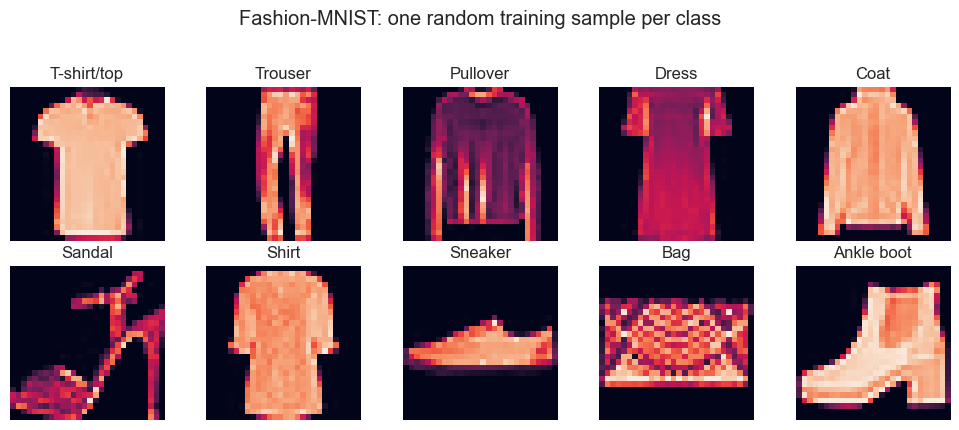

In [5]:
# Plot one random sample per class from the (possibly reduced) training set
rng = np.random.default_rng(SEED)
fig, axes = plt.subplots(2, 5, figsize=(10, 4.2))
picked_indices = []

for c in range(10):
    indices = np.where(y_train == c)[0]
    idx = rng.choice(indices)
    picked_indices.append(idx)

for ax, idx, c in zip(axes.ravel(), picked_indices, range(10)):
    ax.imshow(x_train[idx].squeeze(), vmin=0, vmax=1)
    ax.set_title(class_names[c])
    ax.axis("off")

fig.suptitle("Fashion-MNIST: one random training sample per class", y=1.02)
plt.tight_layout()
plt.show()

---

## 4.3.3 Implement VAE loss: MSE reconstruction + KL divergence

We implement three small, composable functions:

- `reconstruction_loss_mse(x, x_hat)`: per-pixel squared error, summed over spatial/channel dims per sample, then averaged over the batch to return a scalar.
- `kl_loss_diag_gaussian(mu, log_var)`: closed-form KL for a diagonal Gaussian posterior against a standard normal prior, summed over latent dims per sample, then averaged over the batch to return a scalar.
- `vae_total_loss(x, x_hat, mu, log_var)`: total VAE loss as the sum of reconstruction and KL losses (scalar).

In [6]:

def reconstruction_loss_mse(x: tf.Tensor, x_hat: tf.Tensor) -> tf.Tensor:
    """
    Mean squared reconstruction error.
    Reduction: sum over (H, W, C) per sample, then mean over batch -> scalar.
    """
    per_pixel = tf.math.squared_difference(x, x_hat)
    per_sample = tf.reduce_sum(per_pixel, axis=[1, 2, 3])
    return tf.reduce_mean(per_sample)

def kl_loss_diag_gaussian(mu: tf.Tensor, log_var: tf.Tensor) -> tf.Tensor:
    """
    Closed-form KL(q || p) with q = N(mu, diag(exp(log_var))) and p = N(0, I).
    Reduction: sum over latent dims per sample, then mean over batch -> scalar.
    """
    # sigma^2 = exp(log_var)
    kl_per_sample = 0.5 * tf.reduce_sum(
        tf.square(mu) + tf.exp(log_var) - log_var - 1.0, axis=1
    )
    return tf.reduce_mean(kl_per_sample)

def vae_total_loss(x: tf.Tensor, x_hat: tf.Tensor, mu: tf.Tensor, log_var: tf.Tensor) -> tf.Tensor:
    """
    Total VAE loss: reconstruction (MSE) + KL. Returns a scalar.
    """
    recon = reconstruction_loss_mse(x, x_hat)
    kl = kl_loss_diag_gaussian(mu, log_var)
    return recon + kl

---
## 4.3.4 VAE with latent size D_h = 2, training, and reconstructions

What we will do:
- Build an encoder (Conv2D) that outputs `mu` and `log_var` for a 2D latent space, plus a `Sampling` layer (reparameterization).
- Build a decoder (Conv2DTranspose) that maps latent vectors back to 28×28×1 with a final sigmoid.
- Define a minimal `VAE` model with a custom `train_step` that uses the losses from 4.3.3.
- Train the model on Fashion-MNIST and display input vs reconstruction for 10 random test samples.

In [7]:
from tensorflow.keras import layers

In [8]:
class Sampling(layers.Layer):
    def call(self, inputs):
        mu, log_var = inputs
        eps = tf.random.normal(shape=tf.shape(mu))
        return mu + tf.exp(0.5 * log_var) * eps

def build_encoder(latent_dim: int) -> keras.Model:
    inputs = keras.Input(shape=(28, 28, 1))
    x = layers.Conv2D(32, 3, strides=2, padding="same", activation="relu")(inputs)  # 14x14
    x = layers.Conv2D(64, 3, strides=2, padding="same", activation="relu")(x)       # 7x7
    x = layers.Conv2D(64, 3, padding="same", activation="relu")(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation="relu")(x)
    mu = layers.Dense(latent_dim, name="z_mu")(x)          # linear activation
    log_var = layers.Dense(latent_dim, name="z_log_var")(x)  # linear activation
    z = Sampling()([mu, log_var])
    return keras.Model(inputs, [mu, log_var, z], name=f"encoder_ld{latent_dim}")

def build_decoder(latent_dim: int) -> keras.Model:
    inputs = keras.Input(shape=(latent_dim,))
    x = layers.Dense(7 * 7 * 64, activation="relu")(inputs)
    x = layers.Reshape((7, 7, 64))(x)
    x = layers.Conv2DTranspose(64, 3, strides=2, padding="same", activation="relu")(x)  # 14x14
    x = layers.Conv2DTranspose(32, 3, strides=2, padding="same", activation="relu")(x)  # 28x28
    x = layers.Conv2D(16, 3, padding="same", activation="relu")(x)
    outputs = layers.Conv2D(1, 3, padding="same", activation="sigmoid")(x)
    return keras.Model(inputs, outputs, name=f"decoder_ld{latent_dim}")

In [9]:
class VAE(keras.Model):
    def __init__(self, encoder: keras.Model, decoder: keras.Model, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="loss")
        self.recon_loss_tracker = keras.metrics.Mean(name="recon_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [self.total_loss_tracker, self.recon_loss_tracker, self.kl_loss_tracker]

    def train_step(self, data):
        x = data[0] if isinstance(data, tuple) else data
        with tf.GradientTape() as tape:
            mu, log_var, z = self.encoder(x, training=True)
            x_hat = self.decoder(z, training=True)
            recon = reconstruction_loss_mse(x, x_hat)
            kl = kl_loss_diag_gaussian(mu, log_var)
            loss = recon + kl
        grads = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))
        self.total_loss_tracker.update_state(loss)
        self.recon_loss_tracker.update_state(recon)
        self.kl_loss_tracker.update_state(kl)
        return {"loss": self.total_loss_tracker.result(),
                "recon_loss": self.recon_loss_tracker.result(),
                "kl_loss": self.kl_loss_tracker.result()}

    def test_step(self, data):
        x = data[0] if isinstance(data, tuple) else data
        mu, log_var, z = self.encoder(x, training=False)
        x_hat = self.decoder(z, training=False)
        recon = reconstruction_loss_mse(x, x_hat)
        kl = kl_loss_diag_gaussian(mu, log_var)
        loss = recon + kl
        return {"loss": loss, "recon_loss": recon, "kl_loss": kl}

In [10]:
# Instantiate, compile, and train VAE with latent size 2
LATENT_DIM = 2
encoder2 = build_encoder(LATENT_DIM)
decoder2 = build_decoder(LATENT_DIM)
vae2 = VAE(encoder2, decoder2)
vae2.compile(optimizer=keras.optimizers.Adam(1e-3))

EPOCHS = 15
BATCH_SIZE = 128

history = vae2.fit(
    x_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(x_test, None),
    verbose=2,
)

2025-11-20 11:17:00.082732: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2025-11-20 11:17:00.082917: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-11-20 11:17:00.082948: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-11-20 11:17:00.083338: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-11-20 11:17:00.083363: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/15


2025-11-20 11:17:01.050348: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


469/469 - 16s - 33ms/step - kl_loss: 4.0057 - loss: 49.3211 - recon_loss: 45.3154 - val_kl_loss: 0.0000e+00 - val_loss: 0.0000e+00 - val_recon_loss: 0.0000e+00
Epoch 2/15
469/469 - 13s - 28ms/step - kl_loss: 4.8478 - loss: 42.2518 - recon_loss: 37.4040 - val_kl_loss: 0.0000e+00 - val_loss: 0.0000e+00 - val_recon_loss: 0.0000e+00
Epoch 3/15
469/469 - 13s - 28ms/step - kl_loss: 5.0999 - loss: 38.7976 - recon_loss: 33.6977 - val_kl_loss: 0.0000e+00 - val_loss: 0.0000e+00 - val_recon_loss: 0.0000e+00
Epoch 4/15
469/469 - 13s - 28ms/step - kl_loss: 5.8910 - loss: 39.6804 - recon_loss: 33.7893 - val_kl_loss: 0.0000e+00 - val_loss: 0.0000e+00 - val_recon_loss: 0.0000e+00
Epoch 5/15
469/469 - 13s - 28ms/step - kl_loss: 9.2594 - loss: 44.8579 - recon_loss: 35.5986 - val_kl_loss: 0.0000e+00 - val_loss: 0.0000e+00 - val_recon_loss: 0.0000e+00
Epoch 6/15
469/469 - 13s - 28ms/step - kl_loss: 7.8893 - loss: 45.4108 - recon_loss: 37.5215 - val_kl_loss: 0.0000e+00 - val_loss: 0.0000e+00 - val_recon_lo

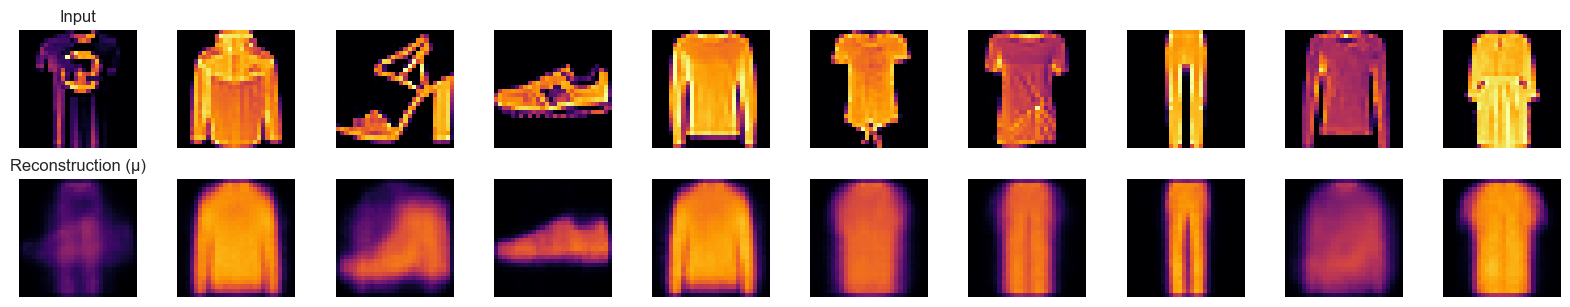

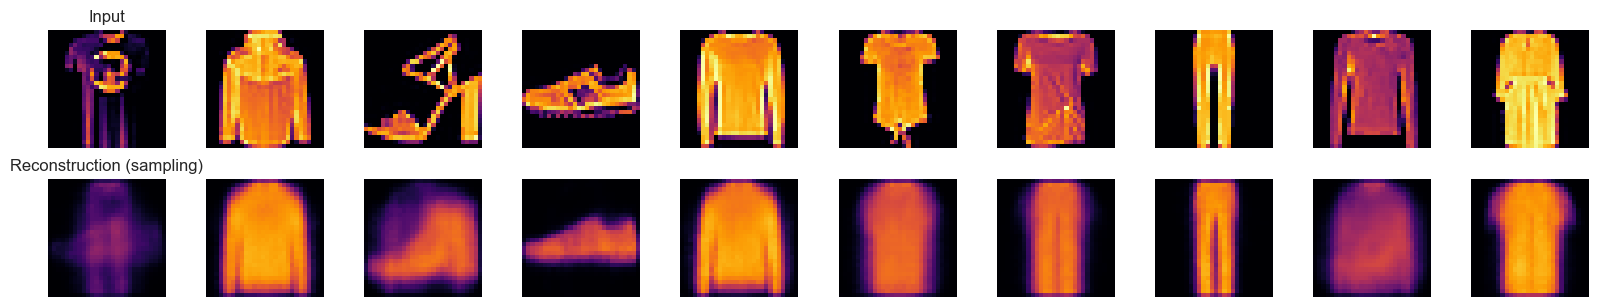

In [11]:


def show_original_vs_recon(model, x, n=10, seed=42, deterministic=True, cmap="inferno"):
    """
    Visualizza n immagini (riga sopra: input, riga sotto: ricostruzione).
    deterministic=True usa z=mu; False usa un nuovo campionamento z=mu+sigma*eps.
    """
    rng = np.random.default_rng(seed)
    idx = rng.choice(len(x), size=n, replace=False)
    x_sel = x[idx]

    # Encoder -> mu, log_var, z (z è già campionato dalla Sampling layer)
    mu, log_var, z = model.encoder.predict(x_sel, verbose=0)

    if deterministic:
        z_used = mu
    else:
        eps = np.random.normal(size=mu.shape)
        z_used = mu + np.exp(0.5 * log_var) * eps

    x_hat = model.decoder.predict(z_used, verbose=0)
    if x_hat.ndim == 3:
        x_hat = x_hat[..., None]

    plt.figure(figsize=(1.6*n, 3.2))
    for i in range(n):
        ax_in = plt.subplot(2, n, i+1)
        ax_in.imshow(x_sel[i].squeeze(), vmin=0, vmax=1, cmap=cmap)
        ax_in.axis("off")
        if i == 0:
            ax_in.set_title("Input")

        ax_rec = plt.subplot(2, n, n+i+1)
        ax_rec.imshow(x_hat[i].squeeze(), vmin=0, vmax=1, cmap=cmap)
        ax_rec.axis("off")
        if i == 0:
            ax_rec.set_title("Reconstruction" + (" (μ)" if deterministic else " (sampling)"))

    plt.tight_layout()
    plt.show()

# Usa il modello corrente (vae2) sui dati di test (x_test):
show_original_vs_recon(vae2, x_test, n=10, seed=42, deterministic=True)   # deterministico (z=mu)
show_original_vs_recon(vae2, x_test, n=10, seed=42, deterministic=False)  # sampling

----
# Model2

# I TRY WITH A DIFFERENT MODEL IF WE CAN DO BETTER

In [17]:
class Sampling(layers.Layer):
    def call(self, inputs):
        mu, log_var = inputs
        eps = tf.random.normal(shape=tf.shape(mu))
        return mu + tf.exp(0.5 * log_var) * eps

def build_encoder(latent_dim: int) -> keras.Model:
    inputs = keras.Input(shape=(28, 28, 1))
    x = layers.Conv2D(32, 3, strides=2, padding="same", activation="relu", kernel_initializer="he_normal")(inputs)  # 14x14
    x = layers.Conv2D(64, 3, strides=2, padding="same", activation="relu", kernel_initializer="he_normal")(x)       # 7x7
    x = layers.Conv2D(128, 3, padding="same", activation="relu", kernel_initializer="he_normal")(x)
    x = layers.Flatten()(x)
    x = layers.Dense(256, activation="relu", kernel_initializer="he_normal")(x)
    mu = layers.Dense(latent_dim, name="z_mu")(x)
    log_var = layers.Dense(latent_dim, name="z_log_var")(x)
    z = Sampling()([mu, log_var])
    return keras.Model(inputs, [mu, log_var, z], name=f"encoder_ld{latent_dim}")

def build_decoder(latent_dim: int) -> keras.Model:
    inputs = keras.Input(shape=(latent_dim,))
    x = layers.Dense(7 * 7 * 128, activation="relu", kernel_initializer="he_normal")(inputs)
    x = layers.Reshape((7, 7, 128))(x)
    x = layers.Conv2DTranspose(128, 3, strides=1, padding="same", activation="relu", kernel_initializer="he_normal")(x)  # 7x7
    x = layers.Conv2DTranspose(64, 3, strides=2, padding="same", activation="relu", kernel_initializer="he_normal")(x)   # 14x14
    x = layers.Conv2DTranspose(32, 3, strides=2, padding="same", activation="relu", kernel_initializer="he_normal")(x)   # 28x28
    outputs = layers.Conv2D(1, 3, padding="same", activation="sigmoid")(x)
    return keras.Model(inputs, outputs, name=f"decoder_ld{latent_dim}")

class VAE(keras.Model):
    def __init__(self, encoder: keras.Model, decoder: keras.Model, kl_final_weight: float = 1.0, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        # KL weight (beta), supports warm-up via a callback (optional)
        self.kl_weight = tf.Variable(kl_final_weight, trainable=False, dtype=tf.float32, name="kl_weight")
        # Trackers
        self.total_loss_tracker = keras.metrics.Mean(name="loss")
        self.recon_loss_tracker = keras.metrics.Mean(name="recon_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [self.total_loss_tracker, self.recon_loss_tracker, self.kl_loss_tracker]

    def compute_losses(self, x, training: bool):
        mu, log_var, z = self.encoder(x, training=training)
        x_hat = self.decoder(z, training=training)
        recon = reconstruction_loss_mse(x, x_hat)
        kl = kl_loss_diag_gaussian(mu, log_var)
        loss = recon + self.kl_weight * kl
        return loss, recon, kl

    def train_step(self, data):
        x = data[0] if isinstance(data, tuple) else data
        with tf.GradientTape() as tape:
            loss, recon, kl = self.compute_losses(x, training=True)
        grads = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))
        self.total_loss_tracker.update_state(loss)
        self.recon_loss_tracker.update_state(recon)
        self.kl_loss_tracker.update_state(kl)
        return {"loss": self.total_loss_tracker.result(),
                "recon_loss": self.recon_loss_tracker.result(),
                "kl_loss": self.kl_loss_tracker.result()}

    def test_step(self, data):
        x = data[0] if isinstance(data, tuple) else data
        loss, recon, kl = self.compute_losses(x, training=False)
        # Update trackers so Keras logs non-zero validation metrics
        self.total_loss_tracker.reset_state()
        self.recon_loss_tracker.reset_state()
        self.kl_loss_tracker.reset_state()
        self.total_loss_tracker.update_state(loss)
        self.recon_loss_tracker.update_state(recon)
        self.kl_loss_tracker.update_state(kl)
        return {"loss": self.total_loss_tracker.result(),
                "recon_loss": self.recon_loss_tracker.result(),
                "kl_loss": self.kl_loss_tracker.result()}

class KLDWarmUpCallback(keras.callbacks.Callback):
    """
    Linearly increase model.kl_weight from 0 to kl_final_weight over warmup_epochs.
    Set warmup_epochs=0 to disable (weight stays at kl_final_weight).
    """
    def __init__(self, warmup_epochs: int = 10, kl_final_weight: float = 1.0):
        super().__init__()
        self.warmup_epochs = max(0, int(warmup_epochs))
        self.kl_final_weight = float(kl_final_weight)

    def on_train_begin(self, logs=None):
        if self.warmup_epochs > 0:
            self.model.kl_weight.assign(0.0)
        else:
            self.model.kl_weight.assign(self.kl_final_weight)

    def on_epoch_end(self, epoch, logs=None):
        if self.warmup_epochs > 0 and epoch + 1 <= self.warmup_epochs:
            frac = (epoch + 1) / self.warmup_epochs
            self.model.kl_weight.assign(self.kl_final_weight * frac)


In [18]:
# Instantiate, compile, and train VAE with latent size 2
LATENT_DIM = 2
encoder2 = build_encoder(LATENT_DIM)
decoder2 = build_decoder(LATENT_DIM)
vae2 = VAE(encoder2, decoder2, kl_final_weight=1.0)
vae2.compile(optimizer=keras.optimizers.Adam(1e-3))

EPOCHS = 40
BATCH_SIZE = 128
KL_WARMUP_EPOCHS = 10  # set to 0 to disable warm-up

callbacks = [KLDWarmUpCallback(warmup_epochs=KL_WARMUP_EPOCHS, kl_final_weight=1.0)]

history = vae2.fit(
    x_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(x_test, None),
    callbacks=callbacks,
    verbose=2,
)

Epoch 1/40
469/469 - 17s - 37ms/step - kl_loss: 32.1637 - loss: 56.0072 - recon_loss: 56.0072 - val_kl_loss: 49.6147 - val_loss: 37.4154 - val_recon_loss: 37.4154
Epoch 2/40
469/469 - 15s - 31ms/step - kl_loss: 10.7997 - loss: 29.7051 - recon_loss: 28.6251 - val_kl_loss: 12.1276 - val_loss: 39.8282 - val_recon_loss: 38.6154
Epoch 3/40
469/469 - 15s - 31ms/step - kl_loss: 8.3241 - loss: 28.7937 - recon_loss: 27.1288 - val_kl_loss: 10.2209 - val_loss: 39.4683 - val_recon_loss: 37.4242
Epoch 4/40
469/469 - 15s - 31ms/step - kl_loss: 8.7374 - loss: 30.2656 - recon_loss: 27.6444 - val_kl_loss: 7.5533 - val_loss: 39.8512 - val_recon_loss: 37.5852
Epoch 5/40
469/469 - 15s - 31ms/step - kl_loss: 8.9807 - loss: 32.7764 - recon_loss: 29.1841 - val_kl_loss: 8.5862 - val_loss: 42.4911 - val_recon_loss: 39.0566
Epoch 6/40
469/469 - 15s - 31ms/step - kl_loss: 13.4600 - loss: 38.7870 - recon_loss: 32.0570 - val_kl_loss: 10.6921 - val_loss: 47.2299 - val_recon_loss: 41.8839
Epoch 7/40
469/469 - 15s - 

---

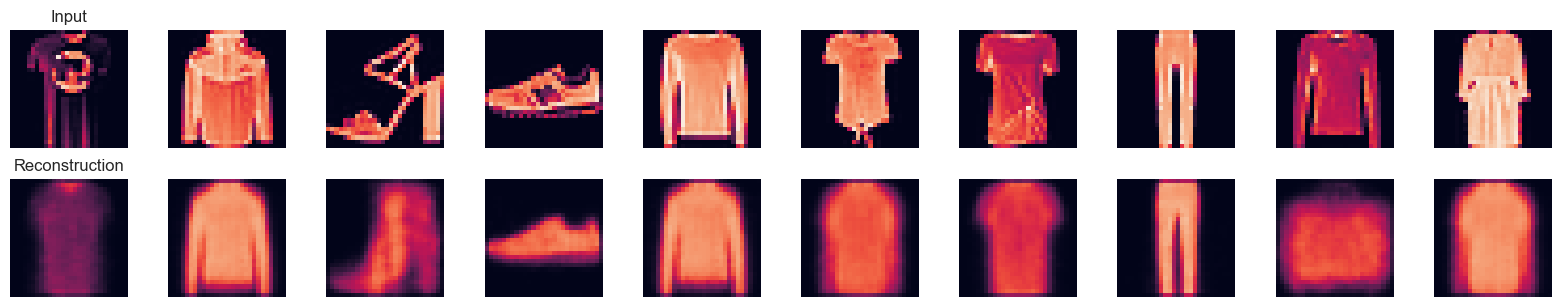

In [19]:
# Utility: show input vs reconstruction for N random test samples
def show_original_vs_recon(model: VAE, x, n=10, seed=SEED):
    rng = np.random.default_rng(seed)
    idx = rng.choice(len(x), size=n, replace=False)
    x_sel = x[idx]
    mu, log_var, z = model.encoder.predict(x_sel, verbose=0)
    x_hat = model.decoder.predict(z, verbose=0)

    fig, axes = plt.subplots(2, n, figsize=(1.6*n, 3.2))
    for i in range(n):
        axes[0, i].imshow(x_sel[i].squeeze(), vmin=0, vmax=1)
        axes[0, i].axis("off")
        if i == 0:
            axes[0, i].set_title("Input")
        axes[1, i].imshow(x_hat[i].squeeze(), vmin=0, vmax=1)
        axes[1, i].axis("off")
        if i == 0:
            axes[1, i].set_title("Reconstruction")
    plt.tight_layout()
    plt.show()

show_original_vs_recon(vae2, x_test, n=10)

---

# Model3

In [21]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

# -------------------------
# Losses (scalar outputs)
# -------------------------
def reconstruction_loss_mse(x: tf.Tensor, x_hat: tf.Tensor, reduction: str = "mean") -> tf.Tensor:
    """
    MSE reconstruction loss.
    reduction:
      - "sum": sum over H,W,C per sample, then mean over batch (scale depends on image size)
      - "mean": mean over H,W,C per sample, then mean over batch (scale invariant to image size)
    Returns a scalar.
    """
    per_pixel = tf.math.squared_difference(x, x_hat)
    if reduction == "sum":
        per_sample = tf.reduce_sum(per_pixel, axis=[1, 2, 3])
    elif reduction == "mean":
        per_sample = tf.reduce_mean(per_pixel, axis=[1, 2, 3])
    else:
        raise ValueError("reduction must be 'sum' or 'mean'")
    return tf.reduce_mean(per_sample)

def kl_loss_diag_gaussian(mu: tf.Tensor, log_var: tf.Tensor) -> tf.Tensor:
    """
    KL(q||p) where q = N(mu, diag(exp(log_var))) and p = N(0, I).
    Sum across latent dims per sample, then mean across batch. Returns a scalar.
    """
    kl_per_sample = 0.5 * tf.reduce_sum(
        tf.square(mu) + tf.exp(log_var) - log_var - 1.0, axis=1
    )
    return tf.reduce_mean(kl_per_sample)

# -------------------------
# Sampling layer
# -------------------------
class Sampling(layers.Layer):
    def call(self, inputs):
        mu, log_var = inputs
        eps = tf.random.normal(shape=tf.shape(mu))
        return mu + tf.exp(0.5 * log_var) * eps

# -------------------------
# Encoder / Decoder builders
# -------------------------
def build_encoder(latent_dim: int) -> keras.Model:
    inputs = keras.Input(shape=(28, 28, 1))
    x = layers.Conv2D(32, 3, strides=2, padding="same", activation="relu", kernel_initializer="he_normal")(inputs)  # 14x14
    x = layers.Conv2D(64, 3, strides=2, padding="same", activation="relu", kernel_initializer="he_normal")(x)       # 7x7
    x = layers.Conv2D(128, 3, padding="same", activation="relu", kernel_initializer="he_normal")(x)
    x = layers.Flatten()(x)
    x = layers.Dense(256, activation="relu", kernel_initializer="he_normal")(x)
    mu = layers.Dense(latent_dim, name="z_mu")(x)
    log_var = layers.Dense(latent_dim, name="z_log_var")(x)
    z = Sampling()([mu, log_var])
    return keras.Model(inputs, [mu, log_var, z], name=f"encoder_ld{latent_dim}")

def build_decoder_upsampling(latent_dim: int) -> keras.Model:
    inputs = keras.Input(shape=(latent_dim,))
    x = layers.Dense(7 * 7 * 128, activation="relu", kernel_initializer="he_normal")(inputs)
    x = layers.Reshape((7, 7, 128))(x)
    # Upsampling-based decoder for cleaner reconstructions
    x = layers.Conv2D(128, 3, padding="same", activation="relu", kernel_initializer="he_normal")(x)  # 7x7
    x = layers.UpSampling2D(size=2)(x)  # 14x14
    x = layers.Conv2D(64, 3, padding="same", activation="relu", kernel_initializer="he_normal")(x)
    x = layers.UpSampling2D(size=2)(x)  # 28x28
    x = layers.Conv2D(32, 3, padding="same", activation="relu", kernel_initializer="he_normal")(x)
    outputs = layers.Conv2D(1, 3, padding="same", activation="sigmoid")(x)
    return keras.Model(inputs, outputs, name=f"decoder_ld{latent_dim}_ups")

# -------------------------
# VAE model with KL warm-up
# -------------------------
class VAE(keras.Model):
    def __init__(
        self,
        encoder: keras.Model,
        decoder: keras.Model,
        kl_final_weight: float = 1.0,
        recon_reduction: str = "mean",
        **kwargs
    ):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.kl_weight = tf.Variable(kl_final_weight, trainable=False, dtype=tf.float32, name="kl_weight")
        self.recon_reduction = recon_reduction
        self.total_loss_tracker = keras.metrics.Mean(name="loss")
        self.recon_loss_tracker = keras.metrics.Mean(name="recon_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        # Keras will log these as loss, recon_loss, kl_loss, and their val_* counterparts
        return [self.total_loss_tracker, self.recon_loss_tracker, self.kl_loss_tracker]

    def compute_losses(self, x, training: bool):
        mu, log_var, z = self.encoder(x, training=training)
        x_hat = self.decoder(z, training=training)
        # reconstruction loss
        per_pixel = tf.math.squared_difference(x, x_hat)
        if self.recon_reduction == "mean":
            recon_per_sample = tf.reduce_mean(per_pixel, axis=[1, 2, 3])
        else:
            recon_per_sample = tf.reduce_sum(per_pixel, axis=[1, 2, 3])
        recon = tf.reduce_mean(recon_per_sample)
        # KL
        kl_per_sample = 0.5 * tf.reduce_sum(tf.square(mu) + tf.exp(log_var) - log_var - 1.0, axis=1)
        kl = tf.reduce_mean(kl_per_sample)
        # total
        loss = recon + self.kl_weight * kl
        return loss, recon, kl

    def train_step(self, data):
        x = data[0] if isinstance(data, tuple) else data
        with tf.GradientTape() as tape:
            loss, recon, kl = self.compute_losses(x, training=True)
        grads = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))
        self.total_loss_tracker.update_state(loss)
        self.recon_loss_tracker.update_state(recon)
        self.kl_loss_tracker.update_state(kl)
        return {"loss": self.total_loss_tracker.result(),
                "recon_loss": self.recon_loss_tracker.result(),
                "kl_loss": self.kl_loss_tracker.result()}

    def test_step(self, data):
        # IMPORTANT: update trackers also in validation so val_recon_loss exists
        x = data[0] if isinstance(data, tuple) else data
        loss, recon, kl = self.compute_losses(x, training=False)
        self.total_loss_tracker.update_state(loss)
        self.recon_loss_tracker.update_state(recon)
        self.kl_loss_tracker.update_state(kl)
        return {"loss": self.total_loss_tracker.result(),
                "recon_loss": self.recon_loss_tracker.result(),
                "kl_loss": self.kl_loss_tracker.result()}


In [22]:
class KLDWarmUpCallback(keras.callbacks.Callback):
    """Linearly increase model.kl_weight from 0 to kl_final_weight over warmup_epochs."""
    def __init__(self, warmup_epochs: int = 40, kl_final_weight: float = 1.0):
        super().__init__()
        self.warmup_epochs = max(0, int(warmup_epochs))
        self.kl_final_weight = float(kl_final_weight)

    def on_train_begin(self, logs=None):
        if self.warmup_epochs > 0:
            self.model.kl_weight.assign(0.0)
        else:
            self.model.kl_weight.assign(self.kl_final_weight)

    def on_epoch_end(self, epoch, logs=None):
        if self.warmup_epochs > 0 and (epoch + 1) <= self.warmup_epochs:
            frac = (epoch + 1) / self.warmup_epochs
            self.model.kl_weight.assign(self.kl_final_weight * frac)

In [26]:
# -------------------------
# Utilities
# -------------------------
def show_original_vs_recon(model: VAE, x, n=10, seed: int = 42, sample: bool = False):
    rng = np.random.default_rng(seed)
    idx = rng.choice(len(x), size=n, replace=False)
    x_sel = x[idx]
    mu, log_var, z_sample = model.encoder.predict(x_sel, verbose=0)
    z = z_sample if sample else mu  # deterministic by default
    x_hat = model.decoder.predict(z, verbose=0)

    fig, axes = plt.subplots(2, n, figsize=(1.6*n, 3.2))
    for i in range(n):
        axes[0, i].imshow(x_sel[i].squeeze(), vmin=0, vmax=1); axes[0, i].axis("off")
        if i == 0: axes[0, i].set_title("Input")
        axes[1, i].imshow(x_hat[i].squeeze(), vmin=0, vmax=1); axes[1, i].axis("off")
        if i == 0: axes[1, i].set_title("Reconstruction")
    plt.tight_layout(); plt.show()

In [24]:
def train_vae_dh2(
    x_train,
    x_test,
    epochs: int = 60,
    batch_size: int = 128,
    lr: float = 1e-4,
    kl_warmup_epochs: int = 40,
    recon_reduction: str = "mean",
):
    enc = build_encoder(latent_dim=2)
    dec = build_decoder_upsampling(latent_dim=2)
    vae = VAE(enc, dec, kl_final_weight=1.0, recon_reduction=recon_reduction)
    vae.compile(optimizer=keras.optimizers.Adam(lr, clipnorm=1.0))
    callbacks = [
    KLDWarmUpCallback(warmup_epochs=kl_warmup_epochs, kl_final_weight=1.0),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_recon_loss", mode="min",
        factor=0.5, patience=5, verbose=1, min_lr=5e-5
    ),
    keras.callbacks.EarlyStopping(
        monitor="val_recon_loss", mode="min",
        patience=10, restore_best_weights=True, verbose=1
    ),
]
    history = vae.fit(
        x_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, None),
        callbacks=callbacks,
        verbose=2,
    )
    return vae, history

In [28]:


# Train (D_h = 2)
model, history = train_vae_dh2(
    x_train=x_train,
    x_test=x_test,
    epochs=60,
    batch_size=128,
    lr=1e-4,
    kl_warmup_epochs=40,
    recon_reduction="mean",  # try "sum" if you want original scaling
)

# Visualize
show_original_vs_recon(model, x_test, n=10, seed=42, sample=False)

Epoch 1/60
469/469 - 114s - 243ms/step - kl_loss: 13.1804 - loss: 0.0609 - recon_loss: 0.0609 - val_kl_loss: 19.6360 - val_loss: 0.0434 - val_recon_loss: 0.0434 - learning_rate: 1.0000e-04
Epoch 2/60


KeyboardInterrupt: 

In [ ]:

import matplotlib.pyplot as plt

def show_original_vs_recon(model, x, n=10, seed=42, deterministic=True, cmap="inferno"):
    """
    Visualizza n immagini (riga sopra: input, riga sotto: ricostruzione).
    deterministic=True usa z=mu; False usa un nuovo campionamento z=mu+sigma*eps.
    """
    rng = np.random.default_rng(seed)
    idx = rng.choice(len(x), size=n, replace=False)
    x_sel = x[idx]

    # Encoder -> mu, log_var, z (z è già campionato dalla Sampling layer)
    mu, log_var, z = model.encoder.predict(x_sel, verbose=0)

    if deterministic:
        z_used = mu
    else:
        eps = np.random.normal(size=mu.shape)
        z_used = mu + np.exp(0.5 * log_var) * eps

    x_hat = model.decoder.predict(z_used, verbose=0)
    if x_hat.ndim == 3:
        x_hat = x_hat[..., None]

    plt.figure(figsize=(1.6*n, 3.2))
    for i in range(n):
        ax_in = plt.subplot(2, n, i+1)
        ax_in.imshow(x_sel[i].squeeze(), vmin=0, vmax=1, cmap=cmap)
        ax_in.axis("off")
        if i == 0:
            ax_in.set_title("Input")

        ax_rec = plt.subplot(2, n, n+i+1)
        ax_rec.imshow(x_hat[i].squeeze(), vmin=0, vmax=1, cmap=cmap)
        ax_rec.axis("off")
        if i == 0:
            ax_rec.set_title("Reconstruction" + (" (μ)" if deterministic else " (sampling)"))

    plt.tight_layout()
    plt.show()

# Usa il modello corrente (vae2) sui dati di test (x_test):
show_original_vs_recon(vae2, x_test, n=10, seed=42, deterministic=True)   # deterministico (z=mu)
show_original_vs_recon(vae2, x_test, n=10, seed=42, deterministic=False)  # sampling

---

# Model 4

In [30]:
# VAE per 4.3.4 — Fashion-MNIST, Dh=2, Conv2DTranspose, MSE+KL
# TensorFlow 2.x / Keras
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

# -----------------------
# Sampling layer (reparametrization trick)
# Sostituiscila con la custom TUWEL se richiesto: stessa firma call([mu, log_var])
# -----------------------
class Sampling(layers.Layer):
    def call(self, inputs):
        mu, log_var = inputs  # log_var = log(sigma^2)
        eps = tf.random.normal(shape=tf.shape(mu))
        return mu + tf.exp(0.5 * log_var) * eps

# -----------------------
# Encoder: 28->14->7, poi Dense -> (mu, logvar) lineari
# -----------------------
def build_encoder(latent_dim=2):
    inp = keras.Input(shape=(28, 28, 1))
    x = layers.Conv2D(32, 3, strides=2, padding="same", activation="relu")(inp)  # 28->14
    x = layers.Conv2D(64, 3, strides=2, padding="same", activation="relu")(x)    # 14->7
    x = layers.Conv2D(128, 3, padding="same", activation="relu")(x)              # 7->7
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation="relu")(x)
    # Linear heads (nessuna attivazione) come richiesto
    z_mu = layers.Dense(latent_dim, name="z_mu")(x)
    z_logvar = layers.Dense(latent_dim, name="z_logvar")(x)
    z = Sampling()([z_mu, z_logvar])
    return keras.Model(inp, [z_mu, z_logvar, z], name="encoder")

# -----------------------
# Decoder: Dense->reshape 7x7x128 -> Conv2DTranspose stride=2 per upsampling
# -----------------------
def build_decoder(latent_dim=2):
    inp = keras.Input(shape=(latent_dim,))
    x = layers.Dense(7 * 7 * 128, activation="relu")(inp)
    x = layers.Reshape((7, 7, 128))(x)
    x = layers.Conv2DTranspose(64, 3, strides=2, padding="same", activation="relu")(x)  # 7->14
    x = layers.Conv2DTranspose(32, 3, strides=2, padding="same", activation="relu")(x)  # 14->28
    out = layers.Conv2DTranspose(1, 3, padding="same", activation="sigmoid")(x)         # 28->28
    return keras.Model(inp, out, name="decoder")

# -----------------------
# VAE model con train_step custom: MSE + KL (coefficiente 1)
# -----------------------
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="loss")
        self.recon_loss_tracker = keras.metrics.Mean(name="recon_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [self.total_loss_tracker, self.recon_loss_tracker, self.kl_loss_tracker]

    @staticmethod
    def mse_recon(x, x_hat):
        # MSE per immagine (somma su pixel), poi media batch -> scalare
        recon_per_img = tf.reduce_sum(tf.square(x - x_hat), axis=[1, 2, 3])
        return tf.reduce_mean(recon_per_img)

    @staticmethod
    def kl_loss(mu, logvar):
        # 0.5 * Σ (μ^2 + σ^2 − log σ^2 − 1) per immagine, poi media batch
        per_dim = tf.square(mu) + tf.exp(logvar) - 1.0 - logvar
        per_img = 0.5 * tf.reduce_sum(per_dim, axis=1)
        return tf.reduce_mean(per_img)

    def train_step(self, data):
        x = data
        with tf.GradientTape() as tape:
            mu, logvar, z = self.encoder(x, training=True)
            x_hat = self.decoder(z, training=True)
            recon = self.mse_recon(x, x_hat)
            kl = self.kl_loss(mu, logvar)
            loss = recon + kl
        grads = tape.gradient(loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(loss)
        self.recon_loss_tracker.update_state(recon)
        self.kl_loss_tracker.update_state(kl)
        return {"loss": self.total_loss_tracker.result(),
                "recon_loss": self.recon_loss_tracker.result(),
                "kl_loss": self.kl_loss_tracker.result()}

    def test_step(self, data):
        x = data
        mu, logvar, z = self.encoder(x, training=False)
        x_hat = self.decoder(z, training=False)
        recon = self.mse_recon(x, x_hat)
        kl = self.kl_loss(mu, logvar)
        loss = recon + kl
        self.total_loss_tracker.update_state(loss)
        self.recon_loss_tracker.update_state(recon)
        self.kl_loss_tracker.update_state(kl)
        return {"loss": self.total_loss_tracker.result(),
                "recon_loss": self.recon_loss_tracker.result(),
                "kl_loss": self.kl_loss_tracker.result()}

# -----------------------
# Plot: 10 input vs ricostruzioni affiancate
# mode='mu' usa z=mu (ricostruzione deterministica), 'sample' usa sampling
# -----------------------
def plot_inputs_vs_recons(x_test, vae, n=10, seed=42, mode="mu", suptitle=None):
    rng = np.random.default_rng(seed)
    idx = rng.choice(len(x_test), size=n, replace=False)
    samples = x_test[idx]

    mu, logvar, z = vae.encoder.predict(samples, verbose=0)
    if mode == "mu":
        z_for_dec = mu
    else:
        # sampling già applicato in forward; rigeneriamo per avere rumore
        eps = np.random.normal(size=mu.shape)
        z_for_dec = mu + np.exp(0.5 * logvar) * eps

    recons = vae.decoder.predict(z_for_dec, verbose=0)

    plt.figure(figsize=(2*n, 4))
    for i in range(n):
        ax = plt.subplot(2, n, i + 1)
        ax.imshow(samples[i].squeeze(), vmin=0, vmax=1)
        ax.axis("off")
        if i == 0:
            ax.set_ylabel("Input", fontsize=11)
        ax2 = plt.subplot(2, n, n + i + 1)
        ax2.imshow(recons[i].squeeze(), vmin=0, vmax=1)
        ax2.axis("off")
        if i == 0:
            ax2.set_ylabel("Recon", fontsize=11)
    if suptitle:
        plt.suptitle(suptitle)
    plt.tight_layout()
    plt.show()

Epoch 1/30
469/469 - 15s - 32ms/step - kl_loss: 3.9380 - loss: 45.2124 - recon_loss: 41.2745 - val_kl_loss: 4.6417 - val_loss: 34.5218 - val_recon_loss: 29.8800
Epoch 2/30
469/469 - 12s - 27ms/step - kl_loss: 4.3152 - loss: 32.5278 - recon_loss: 28.2125 - val_kl_loss: 4.6717 - val_loss: 31.8954 - val_recon_loss: 27.2237
Epoch 3/30
469/469 - 13s - 27ms/step - kl_loss: 4.3853 - loss: 31.3095 - recon_loss: 26.9243 - val_kl_loss: 4.7612 - val_loss: 30.9207 - val_recon_loss: 26.1595
Epoch 4/30
469/469 - 12s - 26ms/step - kl_loss: 4.3966 - loss: 30.8754 - recon_loss: 26.4788 - val_kl_loss: 4.5934 - val_loss: 30.4996 - val_recon_loss: 25.9062
Epoch 5/30
469/469 - 12s - 26ms/step - kl_loss: 4.3954 - loss: 30.7643 - recon_loss: 26.3689 - val_kl_loss: 4.6296 - val_loss: 30.7719 - val_recon_loss: 26.1423
Epoch 6/30
469/469 - 12s - 26ms/step - kl_loss: 4.4204 - loss: 30.8793 - recon_loss: 26.4589 - val_kl_loss: 4.4057 - val_loss: 30.7465 - val_recon_loss: 26.3408
Epoch 7/30
469/469 - 13s - 27ms/st

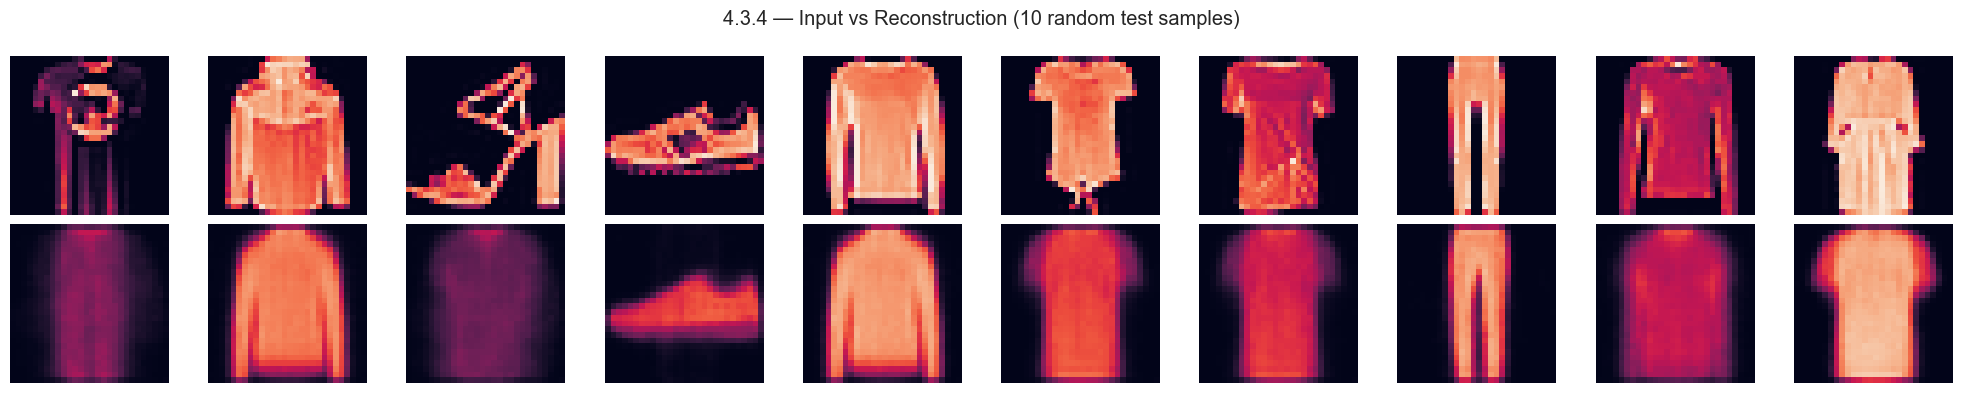

In [31]:


# Costruzione modello Dh=2
enc = build_encoder(latent_dim=2)
dec = build_decoder(latent_dim=2)
vae = VAE(enc, dec)
vae.compile(optimizer=keras.optimizers.Adam(1e-3))

# Training (usa i tuoi x_train/x_test già normalizzati a [0,1])
history = vae.fit(
    x_train,
    validation_data= x_test,
    epochs=30, batch_size=128, verbose=2
)

# Plot richiesto: 10 campioni random, input (sopra) e ricostruzione (sotto)
plot_inputs_vs_recons(x_test, vae, n=10, seed=SEED, mode="mu",
                      suptitle="4.3.4 — Input vs Reconstruction (10 random test samples)")

We see that the model is successful in reconstructing the general shape of the clothing item but finer details like text or patters are lost. We can also observe that for darker original images the reconstruction is more blur, this is due to smaller gradient. 

We will try to do better with another model, although a letent space of dim=2 does not allow for very clear reconstructions especially in grey images. Probably with 

In [32]:
print("Data stats:", x_train.shape, x_train.min(), x_train.max())
# Batch di test
test_batch = x_train[:256]
mu0, logvar0, _, = enc.predict(test_batch, verbose=0)  # Adatta se la tua encoder restituisce diversamente
print("mu shape:", mu0.shape, "logvar shape:", logvar0.shape)
print("mu var per dim:", mu0.var(axis=0))
print("logvar range:", logvar0.min(), logvar0.max())

Data stats: (60000, 28, 28, 1) 0.0 1.0
mu shape: (256, 2) logvar shape: (256, 2)
mu var per dim: [3.7998037 4.382703 ]
logvar range: -9.555915 0.49504018


----

In [13]:
import gc

In [33]:
tf.keras.backend.clear_session();gc.collect();

# Model 5

In [34]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# -------------------------
# Utilities: losses
# -------------------------
def reconstruction_loss_mse(x, x_hat):
    # MSE somma sui pixel per immagine, poi media batch
    return tf.reduce_mean(tf.reduce_sum(tf.square(x - x_hat), axis=[1, 2, 3]))

def reconstruction_loss_bce(x, x_hat):
    # BCE per-pixel, poi media per immagine e media batch
    bce = tf.keras.losses.binary_crossentropy(x, x_hat)  # shape (B,H,W) se C=1
    if len(bce.shape) == 3:
        bce_img = tf.reduce_mean(bce, axis=[1, 2])
    else:
        bce_img = tf.reduce_mean(bce, axis=[1, 2, 3])
    return tf.reduce_mean(bce_img)

def kl_loss_diag_gaussian(mu, log_var, clip_range=None, free_bits_tau=None):
    # Opz. clip per log_var
    if clip_range is not None:
        log_var = tf.clip_by_value(log_var, clip_range[0], clip_range[1])
    per_dim = tf.square(mu) + tf.exp(log_var) - 1.0 - log_var
    kl_per_img = 0.5 * tf.reduce_sum(per_dim, axis=1)
    if free_bits_tau is not None and free_bits_tau > 0.0:
        # Free bits: soglia minima per dimensione (in nats)
        kl_per_dim = 0.5 * per_dim
        kl_per_dim = tf.maximum(kl_per_dim, free_bits_tau)
        kl_per_img = tf.reduce_sum(kl_per_dim, axis=1)
    return tf.reduce_mean(kl_per_img)

# -------------------------
# Sampling layer
# -------------------------
class Sampling(layers.Layer):
    def __init__(self, clip_logvar=None, **kwargs):
        super().__init__(**kwargs)
        self.clip_logvar = clip_logvar
    def call(self, inputs):
        mu, log_var = inputs
        if self.clip_logvar is not None:
            log_var = tf.clip_by_value(log_var, self.clip_logvar[0], self.clip_logvar[1])
        eps = tf.random.normal(shape=tf.shape(mu))
        return mu + tf.exp(0.5 * log_var) * eps, log_var  # ritorno anche log_var (clippato)

# -------------------------
# Encoder / Decoder
# -------------------------
def build_encoder(latent_dim: int, clip_logvar=None) -> keras.Model:
    inputs = keras.Input(shape=(28, 28, 1))
    x = layers.Conv2D(32, 3, strides=2, padding="same", activation="relu", kernel_initializer="he_normal")(inputs)  # 14x14
    x = layers.Conv2D(64, 3, strides=2, padding="same", activation="relu", kernel_initializer="he_normal")(x)       # 7x7
    x = layers.Conv2D(128, 3, padding="same", activation="relu", kernel_initializer="he_normal")(x)
    x = layers.Flatten()(x)
    x = layers.Dense(256, activation="relu", kernel_initializer="he_normal")(x)
    mu = layers.Dense(latent_dim, name="z_mu")(x)
    log_var = layers.Dense(latent_dim, name="z_log_var")(x)
    z, log_var_c = Sampling(clip_logvar=clip_logvar)([mu, log_var])
    return keras.Model(inputs, [mu, log_var_c, z], name=f"encoder_ld{latent_dim}")

def _res_block_same(x, filters, name=None):
    # piccolo residual refinement sullo stesso shape
    y = layers.Conv2D(filters, 3, padding="same", activation="relu", kernel_initializer="he_normal", name=None if name is None else name+"_c1")(x)
    y = layers.Conv2D(filters, 3, padding="same", activation=None, kernel_initializer="he_normal", name=None if name is None else name+"_c2")(y)
    out = layers.Add(name=None if name is None else name+"_add")([x, y])
    out = layers.Activation("relu", name=None if name is None else name+"_act")(out)
    return out

def build_decoder(latent_dim: int, use_residual=True) -> keras.Model:
    inputs = keras.Input(shape=(latent_dim,))
    x = layers.Dense(7 * 7 * 128, activation="relu", kernel_initializer="he_normal")(inputs)
    x = layers.Reshape((7, 7, 128))(x)
    # Refinement a 7x7
    if use_residual:
        x = _res_block_same(x, 128, name="res_7x7")
    x = layers.Conv2DTranspose(128, 3, strides=1, padding="same", activation="relu", kernel_initializer="he_normal")(x)  # 7x7
    x = layers.Conv2DTranspose(64, 3, strides=2, padding="same", activation="relu", kernel_initializer="he_normal")(x)   # 14x14
    if use_residual:
        x = _res_block_same(x, 64, name="res_14x14")
    x = layers.Conv2DTranspose(32, 3, strides=2, padding="same", activation="relu", kernel_initializer="he_normal")(x)   # 28x28
    if use_residual:
        x = _res_block_same(x, 32, name="res_28x28")
    outputs = layers.Conv2D(1, 3, padding="same", activation="sigmoid")(x)
    return keras.Model(inputs, outputs, name=f"decoder_ld{latent_dim}")

# -------------------------
# VAE model
# -------------------------
class VAE(keras.Model):
    def __init__(
        self,
        encoder: keras.Model,
        decoder: keras.Model,
        kl_final_weight: float = 0.5,        # <= riduci a 0.5–0.7 per Dh piccolo
        recon_mode: str = "bce",             # "mse" | "bce" | "hybrid"
        hybrid_alpha: float = 0.5,           # peso BCE nella ibrida: loss = (1-alpha)*MSE + alpha*BCE
        kl_clip: tuple | None = (-6.0, 2.0), # clip su log_var nella KL (backup, oltre al clip nel Sampling)
        free_bits_tau: float | None = None,  # es. 0.1 nats per dim (opzionale)
        **kwargs
    ):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.kl_weight = tf.Variable(kl_final_weight, trainable=False, dtype=tf.float32, name="kl_weight")
        self.recon_mode = recon_mode
        self.hybrid_alpha = hybrid_alpha
        self.kl_clip = kl_clip
        self.free_bits_tau = free_bits_tau
        # metriche
        self.total_loss_tracker = keras.metrics.Mean(name="loss")
        self.recon_loss_tracker = keras.metrics.Mean(name="recon_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [self.total_loss_tracker, self.recon_loss_tracker, self.kl_loss_tracker]

    def _recon_loss(self, x, x_hat):
        if self.recon_mode == "mse":
            return reconstruction_loss_mse(x, x_hat)
        elif self.recon_mode == "bce":
            return reconstruction_loss_bce(x, x_hat)
        else:
            mse = reconstruction_loss_mse(x, x_hat)
            bce = reconstruction_loss_bce(x, x_hat)
            return (1.0 - self.hybrid_alpha) * mse + self.hybrid_alpha * bce

    def compute_losses(self, x, training: bool):
        mu, log_var, z = self.encoder(x, training=training)  # log_var è già clipppato dallo Sampling
        x_hat = self.decoder(z, training=training)
        recon = self._recon_loss(x, x_hat)
        # KL calcolata con eventuale clip (di sicurezza) + free bits
        kl = kl_loss_diag_gaussian(mu, log_var, clip_range=self.kl_clip, free_bits_tau=self.free_bits_tau)
        loss = recon + self.kl_weight * kl
        return loss, recon, kl

    def train_step(self, data):
        x = data[0] if isinstance(data, tuple) else data
        with tf.GradientTape() as tape:
            loss, recon, kl = self.compute_losses(x, training=True)
        grads = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))
        self.total_loss_tracker.update_state(loss)
        self.recon_loss_tracker.update_state(recon)
        self.kl_loss_tracker.update_state(kl)
        return {"loss": self.total_loss_tracker.result(),
                "recon_loss": self.recon_loss_tracker.result(),
                "kl_loss": self.kl_loss_tracker.result()}

    def test_step(self, data):
        x = data[0] if isinstance(data, tuple) else data
        loss, recon, kl = self.compute_losses(x, training=False)
        self.total_loss_tracker.reset_state()
        self.recon_loss_tracker.reset_state()
        self.kl_loss_tracker.reset_state()
        self.total_loss_tracker.update_state(loss)
        self.recon_loss_tracker.update_state(recon)
        self.kl_loss_tracker.update_state(kl)
        return {"loss": self.total_loss_tracker.result(),
                "recon_loss": self.recon_loss_tracker.result(),
                "kl_loss": self.kl_loss_tracker.result()}

class KLDWarmUpCallback(keras.callbacks.Callback):
    """
    Aumenta linearmente model.kl_weight da 0 a kl_final_weight su warmup_epochs.
    """
    def __init__(self, warmup_epochs: int = 15, kl_final_weight: float = 0.5):
        super().__init__()
        self.warmup_epochs = max(0, int(warmup_epochs))
        self.kl_final_weight = float(kl_final_weight)

    def on_train_begin(self, logs=None):
        if self.warmup_epochs > 0:
            self.model.kl_weight.assign(0.0)
        else:
            self.model.kl_weight.assign(self.kl_final_weight)

    def on_epoch_end(self, epoch, logs=None):
        if self.warmup_epochs > 0 and epoch + 1 <= self.warmup_epochs:
            frac = (epoch + 1) / self.warmup_epochs
            self.model.kl_weight.assign(self.kl_final_weight * frac)

In [35]:

from tensorflow import keras
import numpy as np, tensorflow as tf

# Modello
latent_dim = 2
enc = build_encoder(latent_dim, clip_logvar=(-6.0, 2.0))
dec = build_decoder(latent_dim, use_residual=True)
vae = VAE(enc, dec, kl_final_weight=0.5, recon_mode="bce", hybrid_alpha=0.6, kl_clip=(-6.0,2.0))

opt = keras.optimizers.Adam(1e-3, clipnorm=5.0)
vae.compile(optimizer=opt)

cb = [
    KLDWarmUpCallback(warmup_epochs=15, kl_final_weight=0.5),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=6, restore_best_weights=True)
]

vae.fit(x_train, x_train,
        validation_data=(x_test, x_test),
        epochs=40, batch_size=128, verbose=2, callbacks=cb)

# Ricostruzioni deterministiche (z=mu)
mu, logv, z = enc.predict(x_test[:10], verbose=0)
xhat = dec.predict(mu, verbose=0)

Epoch 1/40
469/469 - 41s - 87ms/step - kl_loss: 169.5231 - loss: 0.4019 - recon_loss: 0.4019 - val_kl_loss: 272.9965 - val_loss: 0.3460 - val_recon_loss: 0.3460
Epoch 2/40
469/469 - 36s - 76ms/step - kl_loss: 1.5125 - loss: 0.5113 - recon_loss: 0.4608 - val_kl_loss: 0.5394 - val_loss: 0.4664 - val_recon_loss: 0.4484
Epoch 3/40
469/469 - 81s - 173ms/step - kl_loss: 0.0889 - loss: 0.4855 - recon_loss: 0.4796 - val_kl_loss: 0.0569 - val_loss: 0.4811 - val_recon_loss: 0.4773
Epoch 4/40
469/469 - 43s - 91ms/step - kl_loss: 0.0318 - loss: 0.4867 - recon_loss: 0.4836 - val_kl_loss: 0.0185 - val_loss: 0.4771 - val_recon_loss: 0.4752
Epoch 5/40
469/469 - 44s - 94ms/step - kl_loss: 0.0172 - loss: 0.4857 - recon_loss: 0.4834 - val_kl_loss: 0.0136 - val_loss: 0.4713 - val_recon_loss: 0.4695
Epoch 6/40
469/469 - 43s - 93ms/step - kl_loss: 0.0141 - loss: 0.4847 - recon_loss: 0.4823 - val_kl_loss: 0.0144 - val_loss: 0.4853 - val_recon_loss: 0.4829
Epoch 7/40
469/469 - 43s - 92ms/step - kl_loss: 0.012

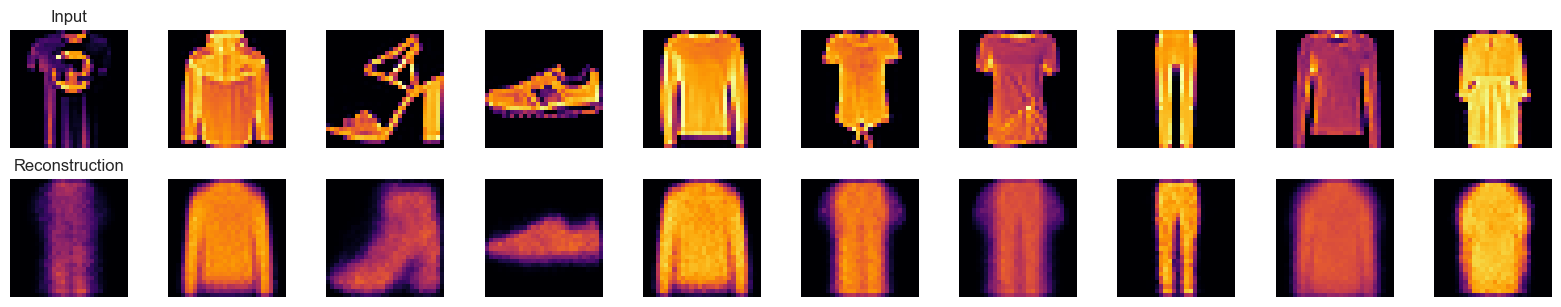

In [36]:
import numpy as np
import matplotlib.pyplot as plt

def show_original_vs_recon(model, x, n=10, seed=42, use_mu=False, cmap="inferno"):
    """
    model.encoder deve restituire (mu, log_var, z)
    use_mu=False => usa z così com'è (campionato nel forward dell'encoder)
    use_mu=True  => forza z = mu (ricostruzione deterministica)
    """
    rng = np.random.default_rng(seed)
    idx = rng.choice(len(x), size=n, replace=False)
    x_sel = x[idx]
    mu, log_var, z = model.encoder.predict(x_sel, verbose=0)
    z_used = mu if use_mu else z
    x_hat = model.decoder.predict(z_used, verbose=0)

    fig, axes = plt.subplots(2, n, figsize=(1.6*n, 3.2))
    for i in range(n):
        axes[0, i].imshow(x_sel[i].squeeze(), vmin=0, vmax=1, cmap=cmap)
        axes[0, i].axis("off")
        if i == 0:
            axes[0, i].set_title("Input")
        axes[1, i].imshow(x_hat[i].squeeze(), vmin=0, vmax=1, cmap=cmap)
        axes[1, i].axis("off")
        if i == 0:
            axes[1, i].set_title("Reconstruction")
    plt.tight_layout()
    plt.show()

# Esempio uso (vae è il tuo modello)
show_original_vs_recon(vae, x_test, n=10, seed=42, use_mu=True)   # deterministico

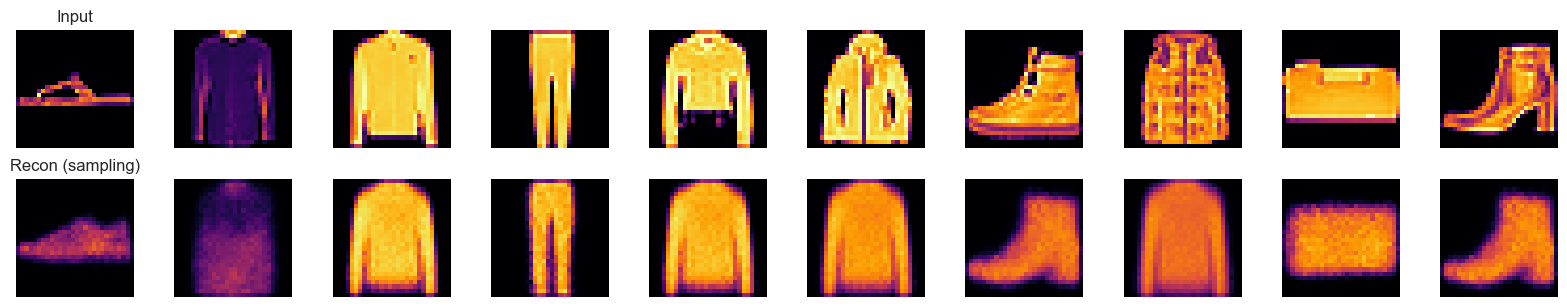

In [37]:
def show_original_vs_recon_sample(model, x, n=10, seed=42, cmap="inferno"):
    rng = np.random.default_rng(seed)
    idx = rng.choice(len(x), size=n, replace=False)
    x_sel = x[idx]
    mu, log_var, z = model.encoder.predict(x_sel, verbose=0)
    eps = np.random.normal(size=mu.shape)
    z_new = mu + np.exp(0.5 * log_var) * eps
    x_hat = model.decoder.predict(z_new, verbose=0)

    fig, axes = plt.subplots(2, n, figsize=(1.6*n, 3.2))
    for i in range(n):
        axes[0, i].imshow(x_sel[i].squeeze(), vmin=0, vmax=1, cmap=cmap)
        axes[0, i].axis("off")
        if i == 0: axes[0, i].set_title("Input")
        axes[1, i].imshow(x_hat[i].squeeze(), vmin=0, vmax=1, cmap=cmap)
        axes[1, i].axis("off")
        if i == 0: axes[1, i].set_title("Recon (sampling)")
    plt.tight_layout()
    plt.show()

# Uso
show_original_vs_recon_sample(vae, x_test, n=10, seed=123)